In [1]:
import pandas as pd, numpy as np
import seaborn as sns

df = pd.read_excel('Concrete_Data.xls',keep_default_na=False)

In [2]:
df.columns = [x.replace('(kg in a m^3 mixture)',"") for x in df.columns]
df.columns = [x.replace("(","") for x in df.columns]
df.columns = [x.replace(")","") for x in df.columns]

## Some scaling might be needed in case I use distance-based algorithms

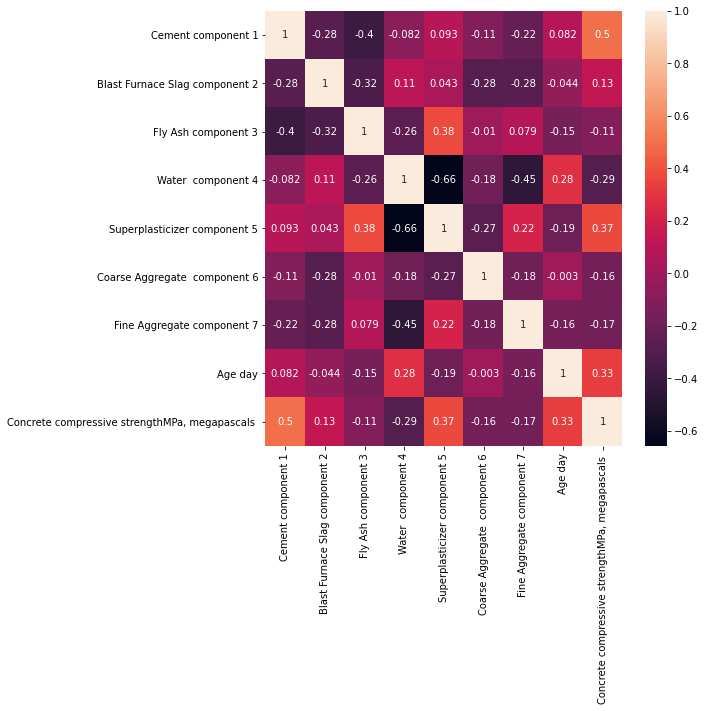

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),annot=True)

plt.show()

## Observations from above: I may not need both water and superplasticizer may not both be needed, and/or both  water and fine aggregate.
### Age and superplasticizer have highest correlation with concrete compressive strength, target variable of interest.

In [ ]:
# plt.hist(df)
# plt.show()

## Model development and evaluation

In [4]:
import xgboost
from xgboost import XGBRegressor

from sklearn.model_selection import KFold, cross_validate, cross_val_score

In [5]:
xgr = XGBRegressor()

x = df.drop(columns=['Concrete compressive strengthMPa, megapascals '])
y = df['Concrete compressive strengthMPa, megapascals ']

cv = KFold(n_splits=7)

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split

#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
# parameters = {'learning_rate': [0.01,1,10], #so called `eta` value
#               'max_depth': [6],
#               'min_child_weight': [10,50],
#               'reg lambda': [5,20],
#               'reg_alpha': [0,10]
#              }

parameters = {'min_child_weight': [10,50],
              'reg lambda': [0,5,20],
              'reg_alpha': [0,5,10],
              'learning_rate':[0.0001,0.001,0.01,0.1],
              'max_depth':[4,8,12]
             }


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

gsXGR = GridSearchCV(xgr, parameters, n_jobs=5, cv=cv, scoring='neg_root_mean_squared_error',
                     refit=True, return_train_score=True)

gsXGR.fit(x,y)

XGB_best = gsXGR.best_estimator_

In [ ]:
cross_validate(XGB_best,x,y,cv=cv, scoring='neg_root_mean_squared_error',return_train_score=True)

In [ ]:
np.mean(cross_val_score(XGB_best,x,y,cv=cv, scoring='neg_root_mean_squared_error'))

In [ ]:
from sklearn.metrics import explained_variance_score

gsXGR = GridSearchCV(xgr, parameters, n_jobs=5, cv=cv, scoring='explained_variance',
                     refit=True, return_train_score=True)

gsXGR.fit(x,y)

XGB_best = gsXGR.best_estimator_

cross_validate(XGB_best,x,y,cv=cv, scoring='explained_variance',return_train_score=True)

In [ ]:
np.mean(cross_val_score(XGB_best,x,y,cv=cv, scoring='explained_variance'))

# My code above didn't improve on original. Could I use AutoML?

In [5]:
%pip install tpot
import tpot
from tpot import TPOTRegressor

  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11959 sha256=9502d7ad8cd3e1674bddb44c21cd9f50518c2724ac9ed5244f747a53d783efe5
  Stored in directory: c:\users\rangy\appdata\local\pip\cache\wheels\a8\bb\8f\6b9328d23c2dcedbfeb8498b9f650d55d463089e3b8fc0bfb2
Successfully built stopit
Note: you may need to restart the kernel to use updated packages.


C:\Users\rangy\anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [7]:
from sklearn.model_selection import RepeatedKFold

cv_tpot = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

reason_model = TPOTRegressor(cv=cv_tpot,
                             generations=10, population_size=50,
                             scoring='neg_root_mean_squared_error', 
                             
                      verbosity=2, random_state=1, n_jobs=-1, 
                      early_stop=15)
reason_model.fit(x,y)

Version 0.11.5 of tpot is outdated. Version 0.11.7 was released Wednesday January 06, 2021.



Generation 1 - Current best internal CV score: -4.244316141049818
Generation 2 - Current best internal CV score: -4.244316141049818
Generation 3 - Current best internal CV score: -4.244316141049818
Generation 4 - Current best internal CV score: -4.244316141049818
Generation 5 - Current best internal CV score: -4.115673883612107
Generation 6 - Current best internal CV score: -4.115673883612107
Generation 7 - Current best internal CV score: -4.051729124196844
Generation 8 - Current best internal CV score: -4.0027015343363255
Generation 9 - Current best internal CV score: -4.0027015343363255
Generation 10 - Current best internal CV score: -3.9802109266806633
Best pipeline: XGBRegressor(PolynomialFeatures(ZeroCount(input_matrix), degree=2, include_bias=False, interaction_only=False), learning_rate=0.1, max_depth=7, min_child_weight=14, n_estimators=100, nthread=1, objective=reg:squarederror, subsample=0.8)


TPOTRegressor(config_dict=None, crossover_rate=0.1,
              cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
              disable_update_check=False, early_stop=15, generations=10,
              log_file=<ipykernel.iostream.OutStream object at 0x0000024682BA7B38>,
              max_eval_time_mins=5, max_time_mins=None, memory=None,
              mutation_rate=0.9, n_jobs=-1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=50,
              random_state=1, scoring='neg_root_mean_squared_error',
              subsample=1.0, template=None, use_dask=False, verbosity=2,
              warm_start=False)

In [8]:
reason_model.export('best_model.py')

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from tpot.builtins import ZeroCount

from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_excel('Concrete_Data.xls', dtype=np.float64)

tpot_data.columns = [x.replace('(kg in a m^3 mixture)',"")for x in df.columns]
tpot_data.columns = [x.replace("(","")for x in df.columns]
tpot_data.columns = [x.replace(")","")for x in df.columns]

features = tpot_data.drop('Concrete compressive strengthMPa, megapascals ', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['Concrete compressive strengthMPa, megapascals '], random_state=1)

# Average CV score on the training set was: -3.9802109266806633
exported_pipeline = make_pipeline(
    ZeroCount(),
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=False),
    XGBRegressor(learning_rate=0.1, max_depth=7, min_child_weight=14, n_estimators=100, nthread=1, objective="reg:squarederror", subsample=0.8)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 1)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [121]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(results,testing_target))
r2 = r2_score(results,testing_target)

print('The root mean square error of predictions is {y} and R-squared value is {x}'.format(y=round(rmse,2),x=round(r2,2)))

The root mean square error of predictions is 4.55 and R-squared value is 0.92


Text(0, 0.5, 'Compressive Strength')

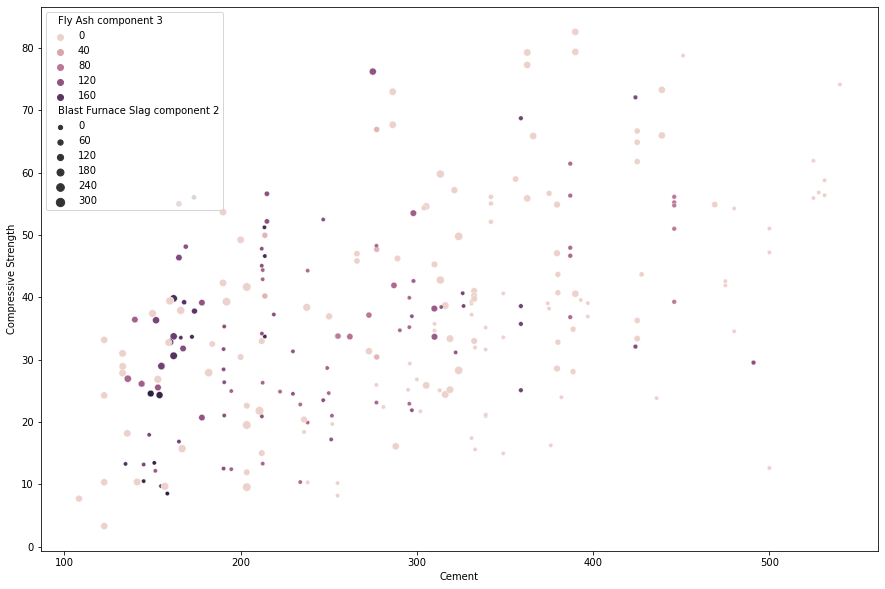

In [76]:
plt.rcParams["figure.figsize"] = (15,10)

sns.scatterplot(x=testing_features['Cement component 1'],y=testing_target.values,
                size=testing_features['Blast Furnace Slag component 2'],
                hue=testing_features['Fly Ash component 3'])

plt.xlabel('Cement')
plt.ylabel('Compressive Strength')

In [127]:
import plotly.express as px

fig = px.scatter(x=testing_features['Cement component 1'],
           y=testing_target.values,
           size=testing_features['Blast Furnace Slag component 2'],
           color=testing_features['Fly Ash component 3'])

fig.update_layout(
    title="Best performing model predictions, color = Fly Ash content",
    xaxis_title="Cement",
    yaxis_title="Compressive strength")

fig.show()


In [128]:
with open('plotly_graph.html', 'w') as f:
    f.write(fig.to_html(include_plotlyjs='cdn'))